# Pricing a European call option on a quantum computer
This notebook is based on the work of M. Q. Hlatshwayo, NQCC.

A call option is a financial contract in which the holder (buyer) has the right (but not the obligation) to buy a specified quantity of a security at a specified price (strike price) within a fixed period of time (until its expiration).


For the writer (seller) of a call option, it represents an obligation to sell the underlying security at the strike price if the option is exercised. The call option writer is paid a premium for taking on the risk associated with the obligation.

Suppose a European call option with strike price $K$ and an underlying asset whose spot price at maturity $S_T$ follows a given distribution.
The corresponding payoff function is defined as:

$$f(S_T) = \max(S_T - K, 0)$$

In the following, a quantum algorithm based on amplitude estimation is used to estimate the expected payoff, i.e., the fair price before discounting, for the option:

$$\mathbb{E}\left[f(S_T) \right] \approx \frac{1}{N} \sum_{i=1}^{N} f\left(S_T^{(i)}\right). $$

The approximation of the objective function and a general introduction to option pricing and risk analysis on quantum computers are given in the following papers:

- [Quantum Risk Analysis. Woerner, Egger. 2018.](https://www.nature.com/articles/s41534-019-0130-6)
- [Option Pricing using Quantum Computers. Stamatopoulos et al. 2019.](https://quantum-journal.org/papers/q-2020-07-06-291/)
## Encoding the probability distribution
We construct a circuit to load a log-normal random distribution into a quantum state.
The distribution is truncated to a given interval $[x_{min}, x_{max}]$ and discretized using $2^n$ grid points, where $n$ denotes the number of qubits used.
The unitary operator corresponding to the circuit implements the following: 

$$\big|0\rangle_{n} \mapsto \big|\psi\rangle_{n} = \sum_{i=0}^{2^n-1} \sqrt{p_i}\big|i\rangle_{n},$$

where $p_i$ denote the probabilities corresponding to the truncated and discretized distribution and where $i$ is mapped to the right interval using the affine map:

$$ \{0, \ldots, 2^n-1\} \ni i \mapsto \frac{x_{max} - x_{min}}{2^n - 1} * i + x_{min} \in [x_{min}, x_{max}].$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit_finance.circuit.library import LogNormalDistribution
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit.circuit.library import LinearAmplitudeFunction, QFT, GroverOperator
from qiskit_algorithms import EstimationProblem, IterativeAmplitudeEstimation
from qiskit.visualization import plot_distribution
from qiskit.primitives import StatevectorSampler as Sampler

In [2]:
# number of qubits to represent the stock price
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

In [3]:
# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

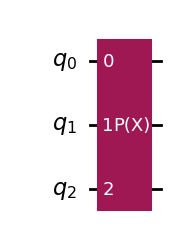

In [4]:
# view circuit 
uncertainty_model.draw('mpl')

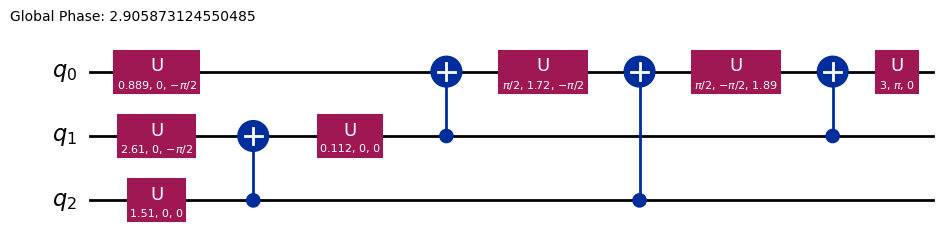

In [5]:
# view detailed circuit in terms of basis gates
uncertainty_model.decompose().decompose().decompose().draw("mpl")

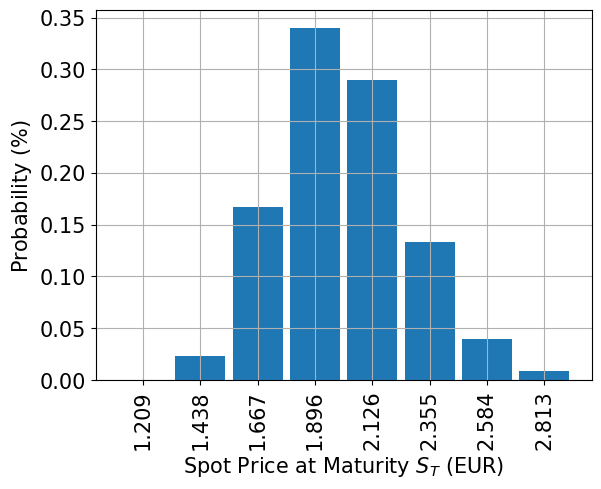

In [6]:
%matplotlib inline
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.figure()
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel(r"Spot Price at Maturity $S_T$ (EUR)", size=15)
plt.ylabel(r"Probability ($\%$)", size=15)
plt.show()

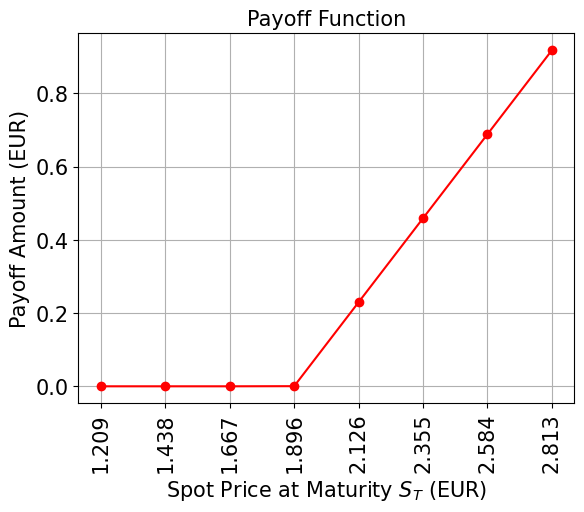

In [7]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 1.896

# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.figure()
plt.plot(x, y, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel(r"Spot Price at Maturity $S_T$ (EUR)", size=15)
plt.ylabel("Payoff Amount (EUR)", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

The payoff function equals zero as long as the spot price at maturity $S_T$ is less than the strike price $K$ and then increases linearly.
The implementation uses a comparator, that flips an ancilla qubit from $\big|0\rangle$ to $\big|1\rangle$ if $S_T \geq K$, and this ancilla is used to control the linear part of the payoff function.

Eventually, we are interested in the probability of measuring $\big|1\rangle$ in the last qubit. Recall that

$$ \mathbb{P}(\textrm{measure 1}) = \mathbb{E}[f(X)] = \sum_{i=0}^{2^n-1}f(i)p_i.$$

For more details on the implementation, we refer to:

[LinearAmplitudeFunction | IBM Qiskit Documentation](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.LinearAmplitudeFunction)

In [8]:
# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective function
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)


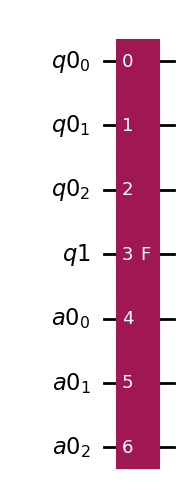

In [9]:
# view payoff function circuit
european_call_objective.draw('mpl')

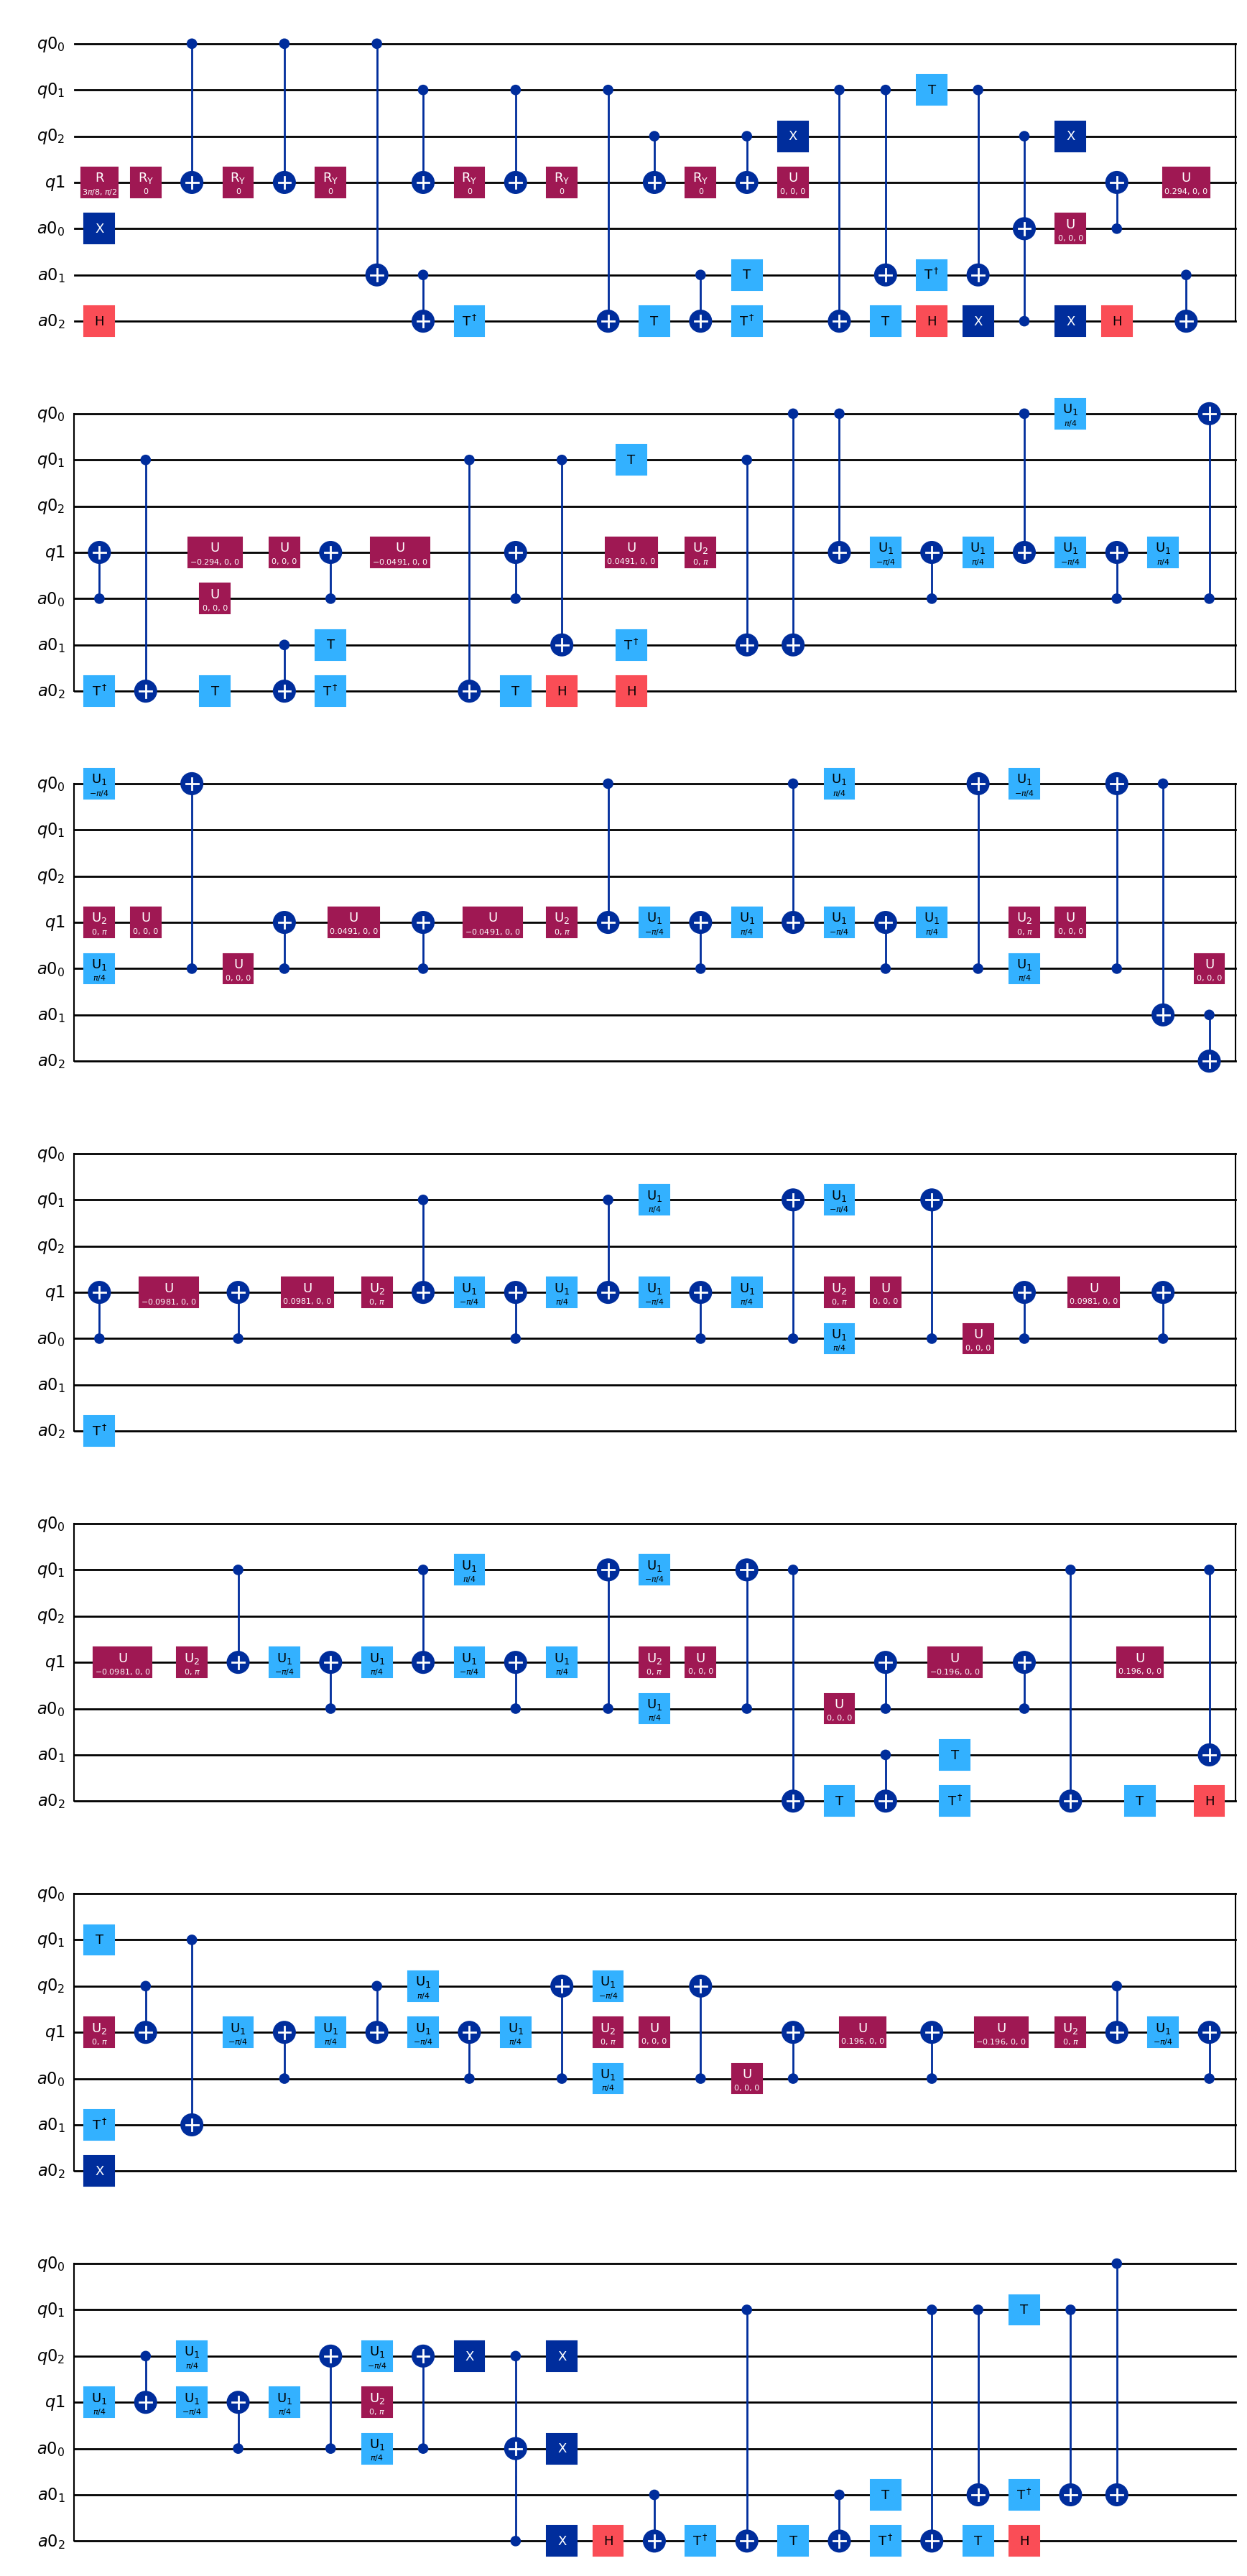

In [10]:
# view payoff function circuit
function_circuit = european_call_objective.decompose().decompose().decompose().decompose().decompose()
function_circuit.draw("mpl")

## Combining the distribution and payoff circuits
We combine the circuits for the underlying distribution and the payoff function, respectively. The $q$ qubit contains the expected value of the payoff. We add a measurement operator for $q$.

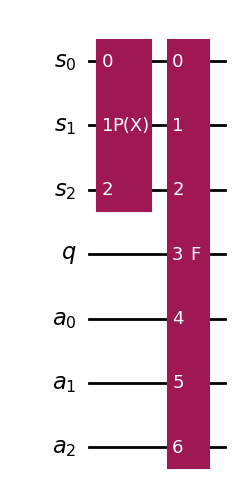

In [11]:
# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
num_qubits = european_call_objective.num_qubits
num_clbits = 1
qreg = QuantumRegister(num_uncertainty_qubits, 's')
qreg2 = QuantumRegister(1, 'q')
qreg3 = AncillaRegister(num_qubits-num_uncertainty_qubits-1, 'a')
creg = ClassicalRegister(num_clbits, 'creg')
european_call = QuantumCircuit(qreg, qreg2, qreg3)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))
european_call.draw("mpl")

We can add a measurement to the objective qubit, in order to run the combined circuit and calculate the average $\hat p$. The average is scaled back from the $[0,1]$ interval to the original $[x_{min}, x_{max}]$ interval.

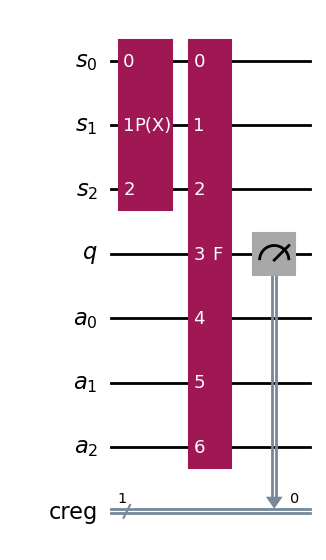

In [12]:
# Add a measurement to the objective qubit
measured_european_call = european_call.copy()
measured_european_call.add_register(creg)
measured_european_call.measure(qreg2, creg)
# draw the circuit
measured_european_call.draw("mpl")

In [13]:
# Run on local simulator
sampler = Sampler()
n_shots = 10000
result = sampler.run([measured_european_call], shots=n_shots).result()
dist = result[0].data.creg.get_int_counts()

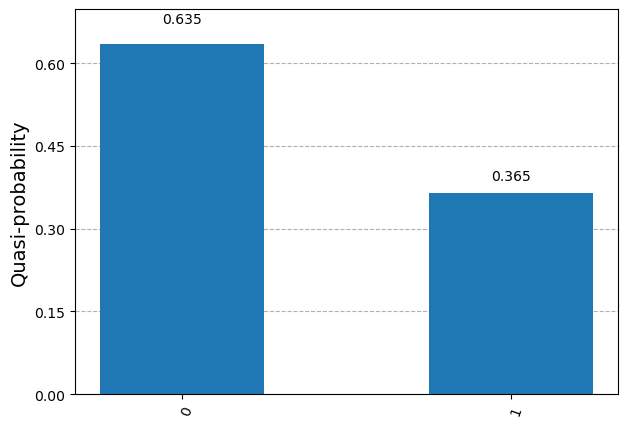

In [14]:
plot_distribution(dist)

In [15]:
p_hat = dist[1]/n_shots
p_std = np.sqrt(p_hat*(1-p_hat)/n_shots)

print("raw estimated average:\t%.4f" % p_hat, ", standard deviation:\t%.4f" % p_std)

expectation = european_call_objective.post_processing(p_hat)
upper = european_call_objective.post_processing(p_hat + 2*p_std)
lower = european_call_objective.post_processing(p_hat - 2*p_std)

print("estimation of expected payoff:\t%.4f" % expectation)
print("lower confidence bound:\t%.4f" % lower)
print("upper confidence bound:\t%.4f" % upper)


raw estimated average:	0.3653 , standard deviation:	0.0048
estimation of expected payoff:	0.1440
lower confidence bound:	0.1215
upper confidence bound:	0.1665


In [16]:
# evaluate exact expected value (normalized to the [0, 1] interval)
exact_value = np.dot(uncertainty_model.probabilities, y)
print("exact expected value from discretization:\t%.4f" % exact_value)

exact expected value from discretization:	0.1623


## Amplitude estimation

### Convergence rate of Classical Monte Carlo

The standard Monte Carlo method for pricing consists in approximating the expected payoff $\mu = \mathbb{E}[f(S_T)]$ as
$$ \mu \approx \tilde{\mu}_N = \frac1{N} \sum_{i=1}^{N} f\left(S_T^{(i)} \right)$$

where $S_T^{(i)},  i=1,...,N $ are independent, identically distributed samples from the probability distribution of the underlying asset $S$ at the expiration time $T$.

A consequence of the central limit theorem is that the estimation error of the Monte Carlo method satisfies
$$ \left|\tilde{\mu}_N-\mu \right| \sim \mathcal{O}\left(\frac1{\sqrt{N}}\right). $$

### Amplitude estimation
Quantum amplitude estimation (QAE) is a quantum algorithm that provides an alternative to classical Monte Carlo in order to compute approximate expectations of random variables.

Suppose we are able to construct a circuit that implements an operator acting on an (n+1) qubit register as follows
$$
    \mathcal{U}|0\rangle_{n+1} = \sqrt{1 - a}\ket{\psi_0}_n \ket{0}+ \sqrt{a}\ket{\psi_1}_n\ket{1},
$$
where $a\in [0,1]$ is an unknown quantity associated with the value $\mu$ which we intend to estimate (e.g., an appropriate re-scaling of $\mu$ to the interval $[0,1]$).

Then, QAE can be used to obtain an estimate of $a$ through repeated controlled applications of the grover operator
$$
    Q = \mathcal{U} S_0 \mathcal{U}^{\dagger}S_{\Psi_0}
$$
and an inverse quantum Fourier transform.

For further details on the algorithm, the reader is refered to [Quantum Amplitude Amplification and Estimation. Brassard et. al.](https://arxiv.org/abs/quant-ph/0005055)

It can be shown that, with high probability ($8/\pi^2 \approx 81\%$), the estimate $\tilde{a}_M$ provided by QAE satisfies
$$
\left| \tilde{a}_M-a\right| \le \frac{2\pi\sqrt{a(1-a)}}{M} + \frac{\pi^2}{M^2}  \sim \mathcal{O}\left(\frac{1}{M}\right),
$$
where $M=2^m$, and $m$ is the number of ancilla qubits used by the algorithm.

That is, QAE provides a quadratic speedup over classical Monte Carlo.

QAE can be applied to the circuit constructed above, which encodes the expected payoff into the amplitude of the objective qubit. To this end, we decompose the circuit into basis gates:

In [17]:
european_call = european_call.decompose().decompose().decompose().decompose().decompose().decompose()

Then, the QAE circuit can be constructed (you can look at the provided code `ae_circuit.py` to see how this is done).

In [18]:
class AECircuit(QuantumCircuit):
    def __init__(self, state_preparation_circuit, num_ancilla_qubits, objective_qubit):
        self.state_preparation_circuit = state_preparation_circuit # The cirtuit implementing operator A
        self.num_ancilla_qubits = num_ancilla_qubits # Number of ancilla qubits (m in IQAE paper)
        self.num_state_qubits = state_preparation_circuit.num_qubits # Number of qubits in circuit A (n+1 in the IQAE paper)
        self.objective_qubit = objective_qubit # Index of the objective qubit within the circuit A (0<=objective_qubit<=num_state_qubits) 
   
        # Initialize circuit 
        ancilla_register = AncillaRegister(self.num_ancilla_qubits, name="ancilla")
        state_register = QuantumRegister(self.num_state_qubits, name="state")
        classical_register = ClassicalRegister(self.num_ancilla_qubits, name="creg")
        super().__init__(
            ancilla_register,
            state_register,
            classical_register
        )
        
        # Hadamard gates on the ancilla qubits
        for j in range(self.num_ancilla_qubits):
            self.h(ancilla_register[j])
            
        # Circuit A on the state and objective qubits
        A_gate = self.state_preparation_circuit.to_gate(label="$A$")
        self.append(A_gate, state_register[:])
       
        self.barrier()
        
        # Powers of Q
        Q = self.groverOp(self.state_preparation_circuit, self.objective_qubit)
        for j in range(num_ancilla_qubits):
            Qj = Q.power(2**j).to_gate(label=f"$Q^{{{2**j}}}$").control(1) # Controlled version of Q^{2j}
            # Apply the controlled Q^{2j} gate on state and objective qubits, controlled by the j-th ancilla qubit
            self.append(Qj, [ancilla_register[self.num_ancilla_qubits-j-1]] + state_register[:])
            
        self.barrier()
       
        # Inverse QFT
        QFT_gate = QFT(num_qubits=self.num_ancilla_qubits, inverse=True, do_swaps=False).to_gate(label="$QFT^\dagger$") 
        self.compose(QFT_gate, ancilla_register, inplace=True)
        
        self.barrier()
        
        # Measure the ancilla qubits
        self.measure(ancilla_register, classical_register)
       
    def groverOp(self, state_preparation_circuit, objective_qubit):
        # construct the grover operator
        oracle = QuantumCircuit(max(state_preparation_circuit.num_qubits - state_preparation_circuit.num_ancillas,1))
        oracle.h(objective_qubit)
        oracle.x(objective_qubit)
        oracle.h(objective_qubit)
        Q = GroverOperator(oracle, state_preparation_circuit) 
        return Q
    
num_ancilla_qubits = 7
qae = AECircuit(state_preparation_circuit=european_call, num_ancilla_qubits=num_ancilla_qubits, objective_qubit=num_uncertainty_qubits)

In [19]:
qae.decompose(reps=5).depth()

454840

### Run QAE on local simulator
We can run QAE on our local simulator, and check that the estimator it produces is close to the MC estimator.

In [20]:
# Run on local simulator
sampler = Sampler()
n_shots = 100
result = sampler.run([qae], shots=n_shots).result()
counts = result[0].data.creg.get_int_counts()

In [21]:
# QAE post-processing
M = 2**num_ancilla_qubits # Number of grid points = 2^num_ancilla_qubits
q = np.array(list(counts.keys()))
theta_estimates = q*np.pi/M
estimates = np.round(np.sin(theta_estimates)**2,15)
probabilities = np.array(list(counts.values()), dtype="float64")
probabilities /= np.sum(probabilities)

# Combine duplicates
new_estimates = list(set(estimates))
new_probabilities = [np.sum(probabilities[estimates==e]) for e in new_estimates]
estimates = np.array(new_estimates)
probabilities = np.array(new_probabilities)

p_mode = estimates[np.argmax(probabilities)] # Extract estimate with highest probability
qae_expected_payoff = european_call_objective.post_processing(p_mode) # Re-scale estimate to get expected payoff
qae_expected_payoff

np.float64(0.17487657133764406)

We can compute the accuracy of QAE as a function of quantum samples

In [22]:
def estimate_ae(num_ancilla_qubits):
    # Construct QAE circuit
    qae = AECircuit(state_preparation_circuit=european_call, num_ancilla_qubits=num_ancilla_qubits, objective_qubit=num_uncertainty_qubits)
    
    # Run on local simulator
    sampler = Sampler()
    n_shots = 100
    result = sampler.run([qae], shots=n_shots).result()
    counts = result[0].data.creg.get_int_counts()
    
    # Post-processing 
    M = 2**num_ancilla_qubits # Number of grid points = 2^num_ancilla_qubits
    q = np.array(list(counts.keys()))
    theta_estimates = q*np.pi/M
    estimates = np.round(np.sin(theta_estimates)**2,15)
    probabilities = np.array(list(counts.values()), dtype="float64")
    probabilities /= np.sum(probabilities)

    # Combine duplicates
    new_estimates = list(set(estimates))
    new_probabilities = [np.sum(probabilities[estimates==e]) for e in new_estimates]
    estimates = np.array(new_estimates)
    probabilities = np.array(new_probabilities)

    p_mode = estimates[np.argmax(probabilities)] # Extract estimate with highest probability
    return p_mode

ancillas_range = np.array(range(1, 8))
qae_estimates = np.array([estimate_ae(num_ancilla_qubits) for num_ancilla_qubits in ancillas_range])

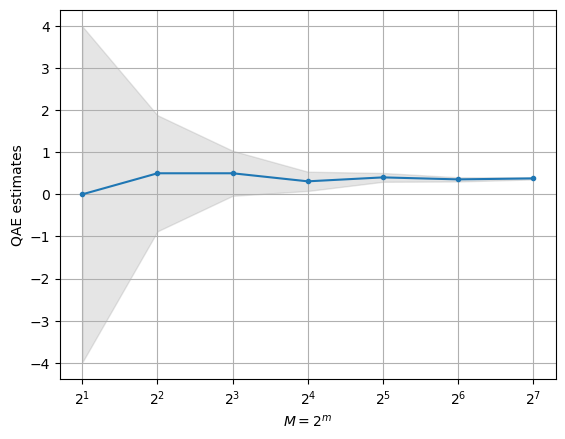

In [23]:
# Plot results
M = 2**np.array(ancillas_range)
qae_expected_payoffs = qae_estimates

plt.semilogx(2**np.array(ancillas_range), qae_expected_payoffs, ".-", base=2) # QAE estimates

# Confidence intervals
M = 2**np.array(ancillas_range)
confidence_intervals = 2*np.pi*np.sqrt(qae_estimates[-1]*(1-qae_estimates[-1]))/M + np.pi**2/M**2
plt.fill_between(M, qae_estimates - abs(confidence_intervals), qae_estimates + abs(confidence_intervals), color='gray', alpha=0.2)

plt.grid()
plt.xlabel("$M=2^m$");
plt.ylabel("QAE estimates");

**Some thoughts** 

Look at the depth of the QAE circuit. Is this algorithm NISQ-ready?

There are some more advanced versions of QAE, which attempt to reduce the required circuit depth without compromising accuracy. We refer the interested reader to
- [Amplitude estimation without phase estimation. Suzuki et. al.](https://arxiv.org/abs/1904.10246),
- [Faster Amplitude Estimation. Nakaji.](https://arxiv.org/pdf/2003.02417),
- [Iterative Quantum Amplitude Estimation. Grinko et. al.](https://arxiv.org/abs/1912.05559).

### Iterative quantum amplitude estimation
[Iterative quantum amplitude estimation (IQAE)](https://arxiv.org/abs/1912.05559) uses the same ideas as canonical QAE while reducing the while reducing circuit depth and the required number of ancillas.


The `qiskit_algorithms` module implements the method [`IterativeAmplitudeEstimation`](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.IterativeAmplitudeEstimation.html), which can be used to estimate the expected payoff as follows:

In [27]:
from qiskit_aer.primitives import Sampler

epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=european_call,
    objective_qubits=[num_uncertainty_qubits],
    post_processing=european_call_objective.post_processing,
)
iae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100})
)

result = iae.estimate(problem)

conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (result.estimation_processed))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.1623
Estimated value:    	0.1676
Confidence interval:	[0.1615, 0.1737]
